# 뉴욕 택시 요금 예측

데이터셋 가져오기

In [245]:
'''
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/new-york-city-taxi-fare-prediction")

print("Path to dataset files:", path)
'''

'\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("dansbecker/new-york-city-taxi-fare-prediction")\n\nprint("Path to dataset files:", path)\n'

In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [247]:
df = pd.read_csv('./train.csv')
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15 UTC,-73.999973,40.748531,-74.016899,40.705993,1
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18 UTC,-73.984756,40.768211,-73.987366,40.760597,1
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00 UTC,-74.002698,40.739428,-73.998108,40.759483,1
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00 UTC,-73.946062,40.777567,-73.953450,40.779687,2


관측치 50000
사이킷런 선형회귀모델, OLS

In [248]:
df_pre_dis = df.iloc[:,3:7].copy()
df_pre_dis
#df_pre_dis.isna().sum()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,-73.844311,40.721319,-73.841610,40.712278
1,-74.016048,40.711303,-73.979268,40.782004
2,-73.982738,40.761270,-73.991242,40.750562
3,-73.987130,40.733143,-73.991567,40.758092
4,-73.968095,40.768008,-73.956655,40.783762
...,...,...,...,...
49995,-73.999973,40.748531,-74.016899,40.705993
49996,-73.984756,40.768211,-73.987366,40.760597
49997,-74.002698,40.739428,-73.998108,40.759483
49998,-73.946062,40.777567,-73.953450,40.779687


위경도 거리계산 (하버사인 공식)

In [249]:
R = 6371.135
#lon이 경도 lat이 위도
lon1 = np.radians(df_pre_dis['pickup_longitude'])
lon2 = np.radians(df_pre_dis['dropoff_longitude'])
lat1 = np.radians(df_pre_dis['pickup_latitude'])
lat2 = np.radians(df_pre_dis['dropoff_latitude'])

delta_lon = lon2 - lon1
delta_lat = lat2 - lat1
    
hav = np.sin(delta_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon/2)**2
    
distance_km = 2 * R * np.arctan2(np.sqrt(hav),np.sqrt(1-hav))
distance = 0.621371192 * distance_km

print(distance)    

0        0.640501
1        5.250781
2        0.863429
3        1.739423
4        1.242245
           ...   
49995    3.069871
49996    0.543529
49997    1.406371
49998    0.413373
49999    0.000000
Length: 50000, dtype: float64


데이터 뽑기

In [250]:
df['distance'] = distance
df_taxi = df[['fare_amount', 'distance']]
df_taxi


,fare_amount,distance
0,4.5,0.640501
1,16.9,5.250781
2,5.7,0.863429
3,7.7,1.739423
4,5.3,1.242245
...,...,...
49995,15.0,3.069871
49996,7.5,0.543529
49997,6.9,1.406371
49998,4.5,0.413373


거리가 0인 값이 존재 (출발 도착이 같나?)
제거하는것이 편할듯

In [251]:
df_taxi = df_taxi[df_taxi['distance'] > 0]
df_taxi = df_taxi[df_taxi['distance'] < 100]
df_taxi = df_taxi[df_taxi['fare_amount'] < 300]
df_taxi

,fare_amount,distance
0,4.5,0.640501
1,16.9,5.250781
2,5.7,0.863429
3,7.7,1.739423
4,5.3,1.242245
...,...,...
49994,8.5,1.423392
49995,15.0,3.069871
49996,7.5,0.543529
49997,6.9,1.406371


회귀분석

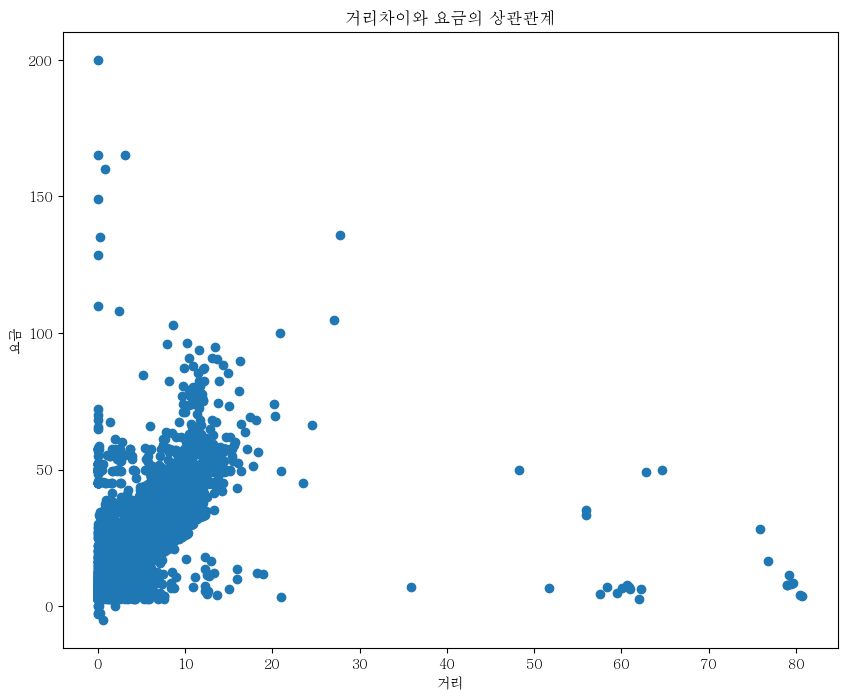

In [252]:
plt.rc('font', family='batang')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(df_taxi['distance'], df_taxi['fare_amount'])
ax.set_xlabel('거리')
ax.set_ylabel('요금')

plt.title('거리차이와 요금의 상관관계')
plt.show()

## ??? 뭔가 이상하다

In [253]:
X = df_taxi.distance.values
Y = df_taxi.fare_amount.values
print(X.shape, Y.shape)

X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
print(X.shape, Y.shape)

(48456,) (48456,)
(48456, 1) (48456, 1)


In [254]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, Y)    

print (lr.coef_[0])

print (lr.intercept_)

[2.61291749]
[5.80948202]


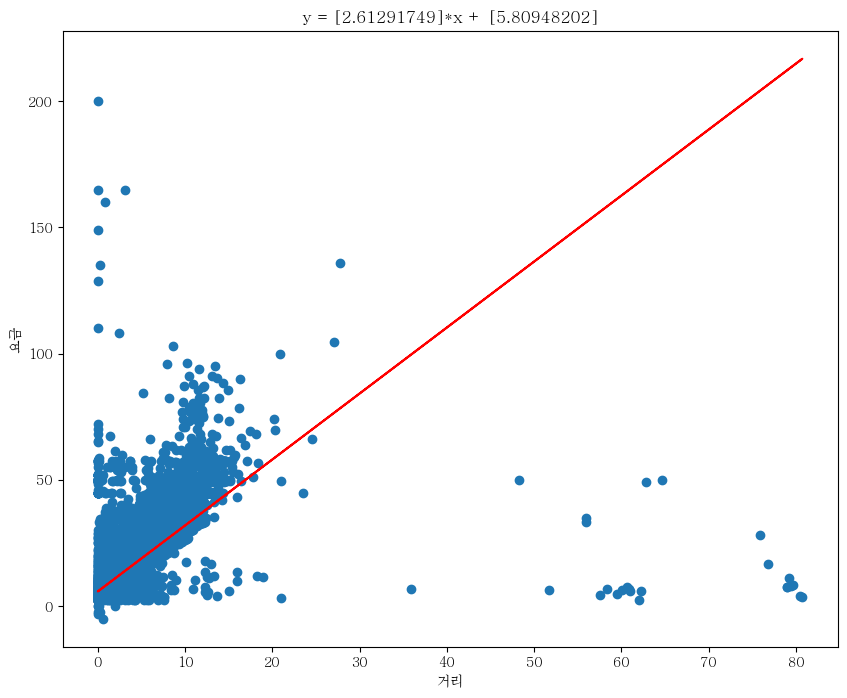

In [255]:
NewY = lr.coef_[0]*X +lr.intercept_

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(X, Y)
ax.set_xlabel('거리')
ax.set_ylabel('요금')

plt.plot(X, NewY, color='red')
plt.title('y = {}*x + {}'.format(lr.coef_[0], lr.intercept_))
plt.show()

In [256]:
import statsmodels.api as sm

res = sm.OLS(Y, sm.add_constant(X)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                 5.521e+04
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:52:05   Log-Likelihood:            -1.5969e+05
No. Observations:               48456   AIC:                         3.194e+05
Df Residuals:                   48454   BIC:                         3.194e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8095      0.038    153.175      0.000       5.735       5.884
x1             2.6129      0.011    234.978      0.000       2.591       2.635
==============================================================================
Omnibus:                    57213.370   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        187898566.549
Skew:                          -5.107   Prob(JB):                         0.00
Kurtosis:                     307.895   Cond. No.                         4.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""